# Semantic Segmentation

In [1]:
from pathlib import Path
import os
import numpy as np
import torch
from torch.utils.tensorboard import SummaryWriter
from ignite.engine import Events, create_supervised_evaluator, create_supervised_trainer
from ignite.metrics import Accuracy, Loss
from matplotlib import pyplot as plt
from torchsummary import summary

from SegmentationAgent import SegmentationAgent
import time

In [2]:
board = SummaryWriter(f'unet-runs/unet-modelce-{int(time.time())}')

Layer (type:depth-idx)                   Output Shape              Param #
├─ModuleList: 1                          []                        --
|    └─DownConv: 2-1                     [-1, 64, 64, 64]          --
|    |    └─Sequential: 3-1              [-1, 64, 128, 128]        1,920
|    |    └─Sequential: 3-2              [-1, 64, 128, 128]        37,056
|    |    └─MaxPool2d: 3-3               [-1, 64, 64, 64]          --
|    └─DownConv: 2-2                     [-1, 128, 32, 32]         --
|    |    └─Sequential: 3-4              [-1, 128, 64, 64]         74,112
|    |    └─Sequential: 3-5              [-1, 128, 64, 64]         147,840
|    |    └─MaxPool2d: 3-6               [-1, 128, 32, 32]         --
|    └─DownConv: 2-3                     [-1, 256, 16, 16]         --
|    |    └─Sequential: 3-7              [-1, 256, 32, 32]         295,680
|    |    └─Sequential: 3-8              [-1, 256, 32, 32]         590,592
|    |    └─MaxPool2d: 3-9               [-1, 256, 16, 16] 

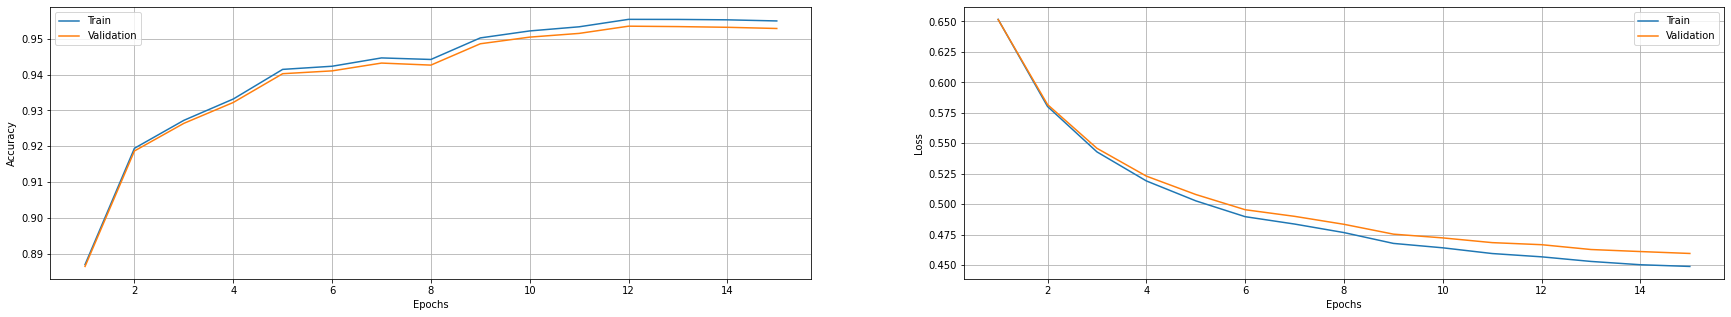

Test Accuracy: 0.9572021484375
Test Loss: 0.4619932174682617


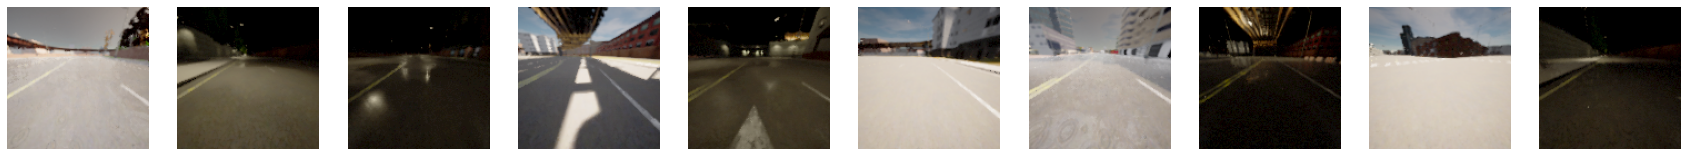

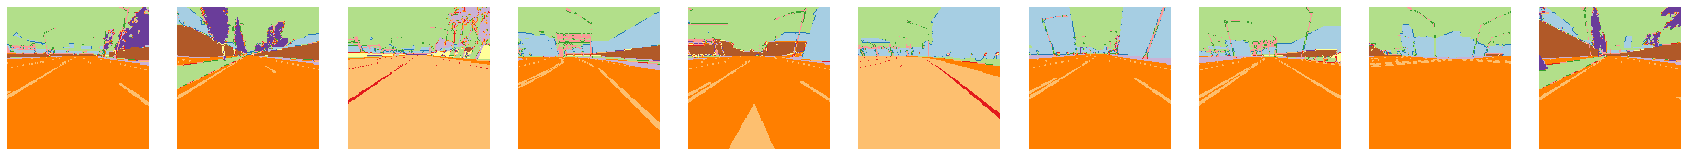

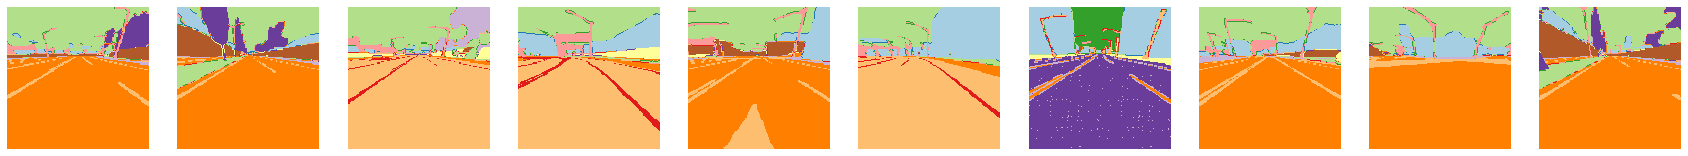

In [3]:
VAL_PERCENTAGE = 0.2  # Amount of data to use for validation
TEST_NUM = 10  # Number of images to set aside for testing and visualization
NUM_CLASSES = 13  # Total number of classes in the dataset
BATCH_SIZE = 16  # Batch size for training
IMG_SIZE = 128  # The input size for model
DATA_PATH = Path('images')  # Location of the dataset
SHUFFLE = True  # Shuffle the dataset before making the split
LR = 0.001  # Learning rate for the model
EPOCHS = 15  # Number of epochs to train the model
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'  # Device used to train

agent = SegmentationAgent(VAL_PERCENTAGE, TEST_NUM, NUM_CLASSES,
                          BATCH_SIZE, IMG_SIZE, DATA_PATH, SHUFFLE, LR, DEVICE)

trainer = create_supervised_trainer(agent.model, agent.optimizer,
                                    agent.criterion)
evaluator = create_supervised_evaluator(agent.model, metrics={
        'accuracy': Accuracy(), 'loss': Loss(agent.criterion)
})

train_accuracy = []
validation_accuracy = []
train_loss = []
validation_loss = []


@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(engine):
    """
    Print training accuracy and loss after each epoch
    """
    evaluator.run(agent.train_loader)
    metrics = evaluator.state.metrics
    avg_accuracy = metrics['accuracy']
    avg_loss = metrics['loss']
    train_accuracy.append(avg_accuracy)
    train_loss.append(avg_loss)
    board.add_scalar('Accuracy/Training Accuracy by Epoch', avg_accuracy, engine.state.epoch)
    board.add_scalar('Loss/Training Loss by Epoch', avg_loss, engine.state.epoch)
    print(
            "Training - Epoch: {} Accuracy: {:.2f} Loss: {:.2f}".format(
                    engine.state.epoch, avg_accuracy, avg_loss))


@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(engine):
    """
    Print validation accuracy and loss after each epoch
    """
    evaluator.run(agent.validation_loader)
    metrics = evaluator.state.metrics
    avg_accuracy = metrics['accuracy']
    avg_loss = metrics['loss']
    validation_accuracy.append(avg_accuracy)
    validation_loss.append(avg_loss)
    board.add_scalar('Accuracy/Validation Accuracy by Epoch', avg_accuracy, engine.state.epoch)
    board.add_scalar('Loss/Validation Loss by Epoch', avg_loss, engine.state.epoch)
    print(
            "Validation - Epoch: {} Accuracy: {:.2f} Loss: {:.2f}".format(
                    engine.state.epoch, avg_accuracy, avg_loss))


# Print summary of the model
summary(agent.model, (3, IMG_SIZE, IMG_SIZE))

# Train model
trainer.run(agent.train_loader, max_epochs=EPOCHS)

# Save the model's weights after training is complete
torch.save(agent.model.state_dict(), 'modelx.pt') # change number if re-running!!!!!

plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(np.arange(len(train_accuracy)) + 1, train_accuracy, label='Train')
plt.plot(np.arange(len(validation_accuracy)) + 1, validation_accuracy,
         label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.subplot(122)
plt.plot(np.arange(len(train_loss)) + 1, train_loss, label='Train')
plt.plot(np.arange(len(validation_loss)) + 1, validation_loss,
         label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Test the model on the test images
images, masks = next(iter(agent.test_loader))
preds = agent.model(images)
acc = Accuracy()
acc.update([preds, masks])
print('Test Accuracy: {}'.format(acc.compute()))

loss = agent.criterion(preds, masks)
loss = loss.cpu().detach().numpy()
print('Test Loss: {}'.format(loss))

images = images.cpu().numpy()
masks = masks.cpu().numpy()
preds = torch.argmax(preds, dim=1).cpu().numpy()

plt.figure(figsize=(30, 10))
for i in range(len(images)):
    plt.subplot(1, len(images), i + 1)
    image = np.moveaxis(images[i], 0, -1)
    image = image * 255
    image = image.astype(int)
    plt.imshow(image)
    plt.axis('off')
plt.show()
plt.figure(figsize=(30, 10))
for i in range(len(masks)):
    plt.subplot(1, len(masks), i + 1)
    plt.imshow(np.moveaxis(masks[i], 0, -1), cmap='Paired')
    plt.axis('off')
plt.show()
plt.figure(figsize=(30, 10))
for i in range(len(preds)):
    plt.subplot(1, len(preds), i + 1)
    plt.imshow(np.moveaxis(preds[i], 0, -1), cmap='Paired')
    plt.axis('off')
plt.show()

In [4]:
board.flush()
board.close()

Layer (type:depth-idx)                   Output Shape              Param #
├─ModuleList: 1                          []                        --
|    └─DownConv: 2-1                     [-1, 64, 64, 64]          --
|    |    └─Sequential: 3-1              [-1, 64, 128, 128]        1,920
|    |    └─Sequential: 3-2              [-1, 64, 128, 128]        37,056
|    |    └─MaxPool2d: 3-3               [-1, 64, 64, 64]          --
|    └─DownConv: 2-2                     [-1, 128, 32, 32]         --
|    |    └─Sequential: 3-4              [-1, 128, 64, 64]         74,112
|    |    └─Sequential: 3-5              [-1, 128, 64, 64]         147,840
|    |    └─MaxPool2d: 3-6               [-1, 128, 32, 32]         --
|    └─DownConv: 2-3                     [-1, 256, 16, 16]         --
|    |    └─Sequential: 3-7              [-1, 256, 32, 32]         295,680
|    |    └─Sequential: 3-8              [-1, 256, 32, 32]         590,592
|    |    └─MaxPool2d: 3-9               [-1, 256, 16, 16] 

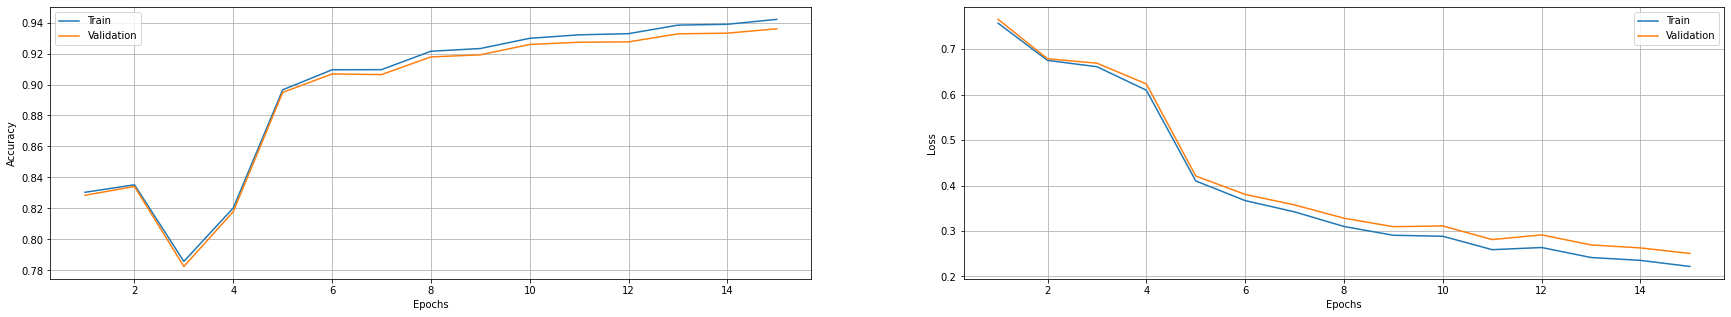

Test Accuracy: 0.91680908203125
Test Loss: 0.27428993582725525


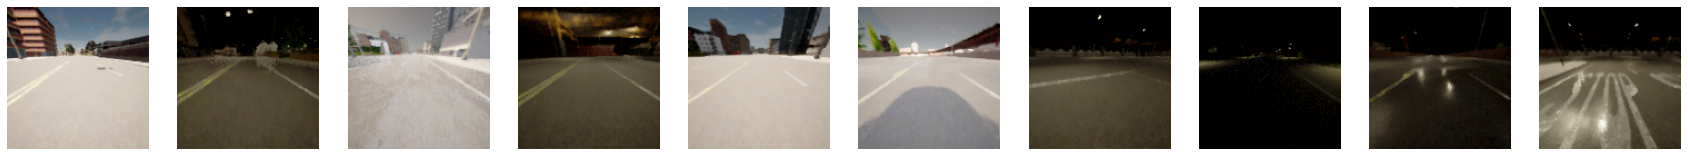

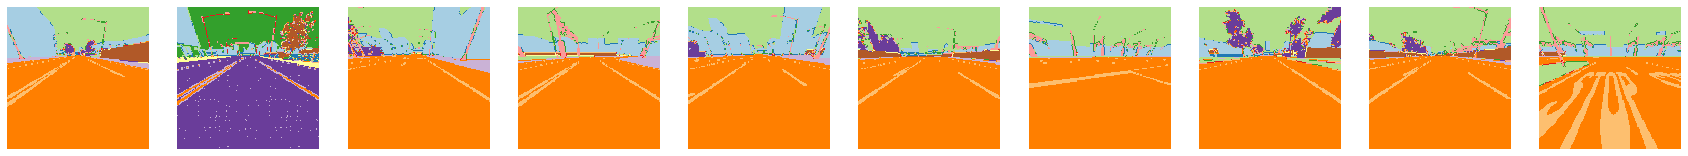

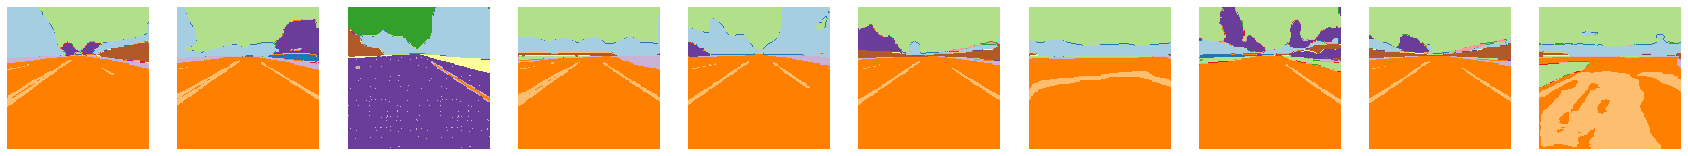

In [3]:
VAL_PERCENTAGE = 0.2  # Amount of data to use for validation
TEST_NUM = 10  # Number of images to set aside for testing and visualization
NUM_CLASSES = 13  # Total number of classes in the dataset
BATCH_SIZE = 32  # Batch size for training
IMG_SIZE = 128  # The input size for model
DATA_PATH = Path('images')  # Location of the dataset
SHUFFLE = True  # Shuffle the dataset before making the split
LR = 0.001  # Learning rate for the model
EPOCHS = 15  # Number of epochs to train the model
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'  # Device used to train

agent = SegmentationAgent(VAL_PERCENTAGE, TEST_NUM, NUM_CLASSES,
                          BATCH_SIZE, IMG_SIZE, DATA_PATH, SHUFFLE, LR, DEVICE, False)

trainer = create_supervised_trainer(agent.model, agent.optimizer,
                                    agent.criterion)
evaluator = create_supervised_evaluator(agent.model, metrics={
        'accuracy': Accuracy(), 'loss': Loss(agent.criterion)
})

train_accuracy = []
validation_accuracy = []
train_loss = []
validation_loss = []


@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(engine):
    """
    Print training accuracy and loss after each epoch
    """
    evaluator.run(agent.train_loader)
    metrics = evaluator.state.metrics
    avg_accuracy = metrics['accuracy']
    avg_loss = metrics['loss']
    train_accuracy.append(avg_accuracy)
    train_loss.append(avg_loss)
    board.add_scalar('Accuracy/Training Accuracy by Epoch', avg_accuracy, engine.state.epoch)
    board.add_scalar('Loss/Training Loss by Epoch', avg_loss, engine.state.epoch)
    print(
            "Training - Epoch: {} Accuracy: {:.2f} Loss: {:.2f}".format(
                    engine.state.epoch, avg_accuracy, avg_loss))


@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(engine):
    """
    Print validation accuracy and loss after each epoch
    """
    evaluator.run(agent.validation_loader)
    metrics = evaluator.state.metrics
    avg_accuracy = metrics['accuracy']
    avg_loss = metrics['loss']
    validation_accuracy.append(avg_accuracy)
    validation_loss.append(avg_loss)
    board.add_scalar('Accuracy/Validation Accuracy by Epoch', avg_accuracy, engine.state.epoch)
    board.add_scalar('Loss/Validation Loss by Epoch', avg_loss, engine.state.epoch)
    print(
            "Validation - Epoch: {} Accuracy: {:.2f} Loss: {:.2f}".format(
                    engine.state.epoch, avg_accuracy, avg_loss))


# Print summary of the model
summary(agent.model, (3, IMG_SIZE, IMG_SIZE))

# Train model
trainer.run(agent.train_loader, max_epochs=EPOCHS)

# Save the model's weights after training is complete
torch.save(agent.model.state_dict(), 'modelx.pt') # change number if re-running!!!!!

plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(np.arange(len(train_accuracy)) + 1, train_accuracy, label='Train')
plt.plot(np.arange(len(validation_accuracy)) + 1, validation_accuracy,
         label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.subplot(122)
plt.plot(np.arange(len(train_loss)) + 1, train_loss, label='Train')
plt.plot(np.arange(len(validation_loss)) + 1, validation_loss,
         label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Test the model on the test images
images, masks = next(iter(agent.test_loader))
preds = agent.model(images)
acc = Accuracy()
acc.update([preds, masks])
print('Test Accuracy: {}'.format(acc.compute()))

loss = agent.criterion(preds, masks)
loss = loss.cpu().detach().numpy()
print('Test Loss: {}'.format(loss))

images = images.cpu().numpy()
masks = masks.cpu().numpy()
preds = torch.argmax(preds, dim=1).cpu().numpy()

plt.figure(figsize=(30, 10))
for i in range(len(images)):
    plt.subplot(1, len(images), i + 1)
    image = np.moveaxis(images[i], 0, -1)
    image = image * 255
    image = image.astype(int)
    plt.imshow(image)
    plt.axis('off')
plt.show()
plt.figure(figsize=(30, 10))
for i in range(len(masks)):
    plt.subplot(1, len(masks), i + 1)
    plt.imshow(np.moveaxis(masks[i], 0, -1), cmap='Paired')
    plt.axis('off')
plt.show()
plt.figure(figsize=(30, 10))
for i in range(len(preds)):
    plt.subplot(1, len(preds), i + 1)
    plt.imshow(np.moveaxis(preds[i], 0, -1), cmap='Paired')
    plt.axis('off')
plt.show()